# Constructing a network of Wikipedia Pages

## Introduction

In this notebook, we're gonna show a step-by-step process on how to build a network (graph) from automatically collecting Wikipedia data.

> This notebook is a version of the notebook made available on the **Week 7** on this [GitHub Repository](https://github.com/ivanovitchm/network_analysis).


In our example, we're gonna use central **Wikipedia page** as a 'seed' and collect all the citations that this page has (they will be considered as its directed neighbours in the network). Then, for each of these pages, we do the same process. 

To do this, we're gonna be using the concept of BFS (breadth-first search), which is an algorithm to walk in graphs. It is based on the 'layers' of a graph's entry, the first layer it's the entry's neighbours, the second, the neighbours of the neighbors, and so on.

The algorithm is called *breadth-first* because it consumes the nodes layer by layer.

<img width="200" src="https://drive.google.com/uc?export=view&id=1t9ZXB5Q-wRt_qWbf8eU_1RiTwVGaStHU">

Doing this process on wikipedia pages allow us to build a Directed Connected Graph, where each node is a page and, its neighbours, are the pages citations.








## Scraping Wikipedia and building the network

**Choosing the Seed**

The first step of our research is to decide the central Wikipedia Page.
This page will contain the main subject of our network.

We choose to take an everyday topic that follows humankind for millennia, that can highlight characteristics of all cultures and societies.

For these purposes, we decided to start in the Chair's main article.

So, with the seed in hand, we can go ahead and build the Scraper.




In [1]:
!pip install networkx==2.6.2
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=d2c541b45d5326a523d3531aa20a2f56a0d9129ef0eb3a51995331e15831924e
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [2]:
from operator import itemgetter
import networkx as nx
import wikipedia

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

Defining initial conditions.

In [3]:
## Chair
SEED = 'Chair'

todo_lst = [(0, SEED)] # List of the next links to be processed. The SEED is in the layer 0
todo_set = set(SEED) # Set of the next links to be processed. Useful to speed up searches.
done_set = set() # Set of already visited nodes.

In [4]:
g = nx.DiGraph()
layer, page = todo_lst[0]

In [5]:
wikipedia.page('Chair', auto_suggest=False)

<WikipediaPage 'Chair'>

<center>
  <div color='r'> WARNING </div>
</center>

This is the cell where we do the scrapping loop. Depending on your PC and internet setup, this cell can take a while tu run completely.


In [6]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst, 
  # and add it to the set of processed pages. 
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)
  
  # Show progress
  print(layer, page) 
  
  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page, auto_suggest=False)
  except:
    layer, page = todo_lst[0]
    print("Could not load", page)
    continue
  
  for link in wiki.links:
    link = link.title()
    if not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      g.add_edge(page, link)
  layer, page = todo_lst[0]

0 Chair
1 2012 Republican Political Convention
1 Aeron Chair
1 American National Standards Institute
1 Anthropometry
1 Antimacassar
1 Armrest
1 Ash Tree
1 Ashanti Empire
1 Bar Stool
Could not load Barack Obama
1 Barack Obama
1 Bean Bag
Could not load Bean Bag Chair
1 Bean Bag Chair
Could not load Bench (Furniture)
1 Bench (Furniture)
Could not load Board Of Directors
1 Board Of Directors
Could not load Broken Chair
1 Broken Chair
1 Butterfly Chair
Could not load Buttock Popliteal
1 Buttock Popliteal
Could not load Buttocks
1 Buttocks
1 Canada
1 Caning (Furniture)
Could not load Caster
1 Caster
1 Cattail
1 Chair (Disambiguation)
Could not load Chair Of The Board
1 Chair Of The Board
Could not load Chair Pose
1 Chair Pose
Could not load Chair Squat
1 Chair Squat
Could not load Charles Eames
1 Charles Eames
1 Chest (Furniture)
Could not load China
1 China
1 Clint Eastwood
1 Cluster Bomb
1 Concertmaster
1 Coronation Chair
1 Corrugated Cardboard
1 Cushion
1 Den (Room)
Could not load Dental 

/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Seat
1 Seat
1 Seating Assignment
Could not load Shoulders
1 Shoulders
1 Sitting
1 Splat (Furniture)
Could not load Stele
1 Stele
1 Steve Mann (Inventor)
Could not load Swivel Chair
1 Swivel Chair
1 The Conversation (Website)
Could not load Thomas Edward Bowdich
1 Thomas Edward Bowdich
1 Throne
1 Tokujin Yoshioka
1 Toronto
1 Tuileries Garden
1 Twelve Chairs
1 Ukraine
1 United Kingdom
1 Upholstery
1 Ventilation (Architecture)
Could not load Wheelchair
1 Wheelchair
1 Whiplash (Medicine)
Could not load White
1 White
1 Wood
1 Writing Desk
Could not load 1856 Republican National Convention
CPU times: user 6 s, sys: 496 ms, total: 6.49 s
Wall time: 3min


Lets see the info abour our network.

In [7]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

32065 nodes, 42148 edges


The network of interest is now in the variable **g**. 

Before continue, we need to do a few cleaning steps on our network.

## Preprocessing Steps

### Truncate the network

This is the most important cleaning step. 

As the purpose of the network is to adequately represent the relation of a main page or a main subject with its surroundings pages, we need to assure that each node in our graph is representative.

By creating the network with the BFS method (discussed in Introduction), we get **a lot** of non-representative nodes, i.e. , nodes with only one neighbour.

Lets remove this nodes.


Text(0.5, 36.72222222222221, '% of nodes')

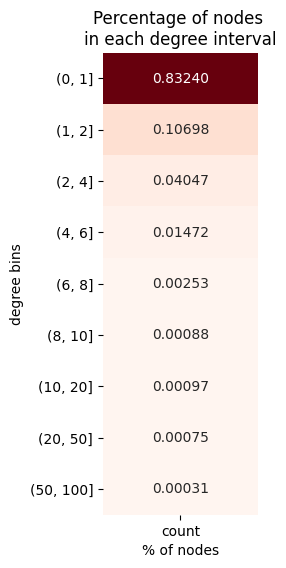

In [51]:

# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  
degree_df = pd.DataFrame(degree_sequence, columns=['degree']).reset_index()

# Determining bins to count nodes
bins = [0, 1, 2, 4, 6, 8, 10, 20, 50, 100]

# Creating dataframe with bins count
degree_bins_count = pd.DataFrame( degree_df.groupby( pd.cut(degree_df['degree'], bins) )['index'].count() ).rename( columns={'index':'count'} )
# Transforming into %
degree_bins_count['count'] = degree_bins_count['count']/degree_bins_count['count'].sum()

fig, ax = plt.subplots( figsize=(2,6) )
ax.set_title("Percentage of nodes \nin each degree interval")
sns.heatmap(degree_bins_count, annot=True, fmt='.5f', cbar=False, cmap='Reds', linecolor='black', ax=ax)

ax.set_ylabel("degree bins")
ax.set_xlabel("% of nodes")

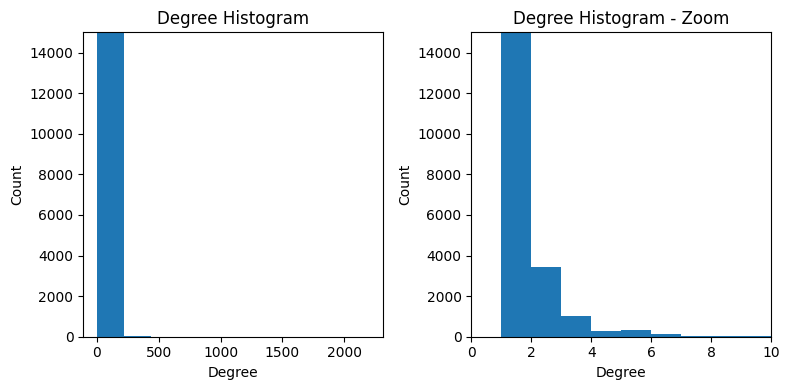

In [8]:
plt.style.use("default")

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,15000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

plt.tight_layout()
plt.show()

As we can see, over 14 K nodes are purely '*leaves*' (nodes with only one conection) on our graph.



In [9]:
# filter nodes with degree greater than or equal to 2
core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

# select a subgraph with 'core' nodes
gsub = nx.subgraph(g, core)

print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

# Save the network
nx.write_graphml(gsub, "chair_network.graphml")

5430 nodes, 15513 edges


In [10]:
print("Nodes removed: {:.2f}%".format(100*(1 - len(gsub.nodes)/len(g.nodes))))
print("Edges removed: {:.2f}%".format(100*(1 - len(gsub.edges)/len(g.edges))))
print("Final Edges per nodes ration: {:.2f}".format(len(gsub.edges)/len(gsub.nodes)))

Nodes removed: 83.07%
Edges removed: 63.19%
Final Edges per nodes ration: 2.86


In [59]:
graphs_mdata_df = pd.DataFrame( columns=['Original', 'Cleaned'], index=['Nodes', 'Edges', 'Edges per Nodes'] )
graphs_mdata_df['Original'] = [ len(g.nodes), len(g.edges), len(g.edges)/len(g.nodes) ]
graphs_mdata_df['Cleaned'] = [ len(gsub.nodes), len(gsub.edges), len(gsub.edges)/len(gsub.nodes) ]
graphs_mdata_df.round(2)

,Original,Cleaned
Nodes,32065.00,5430.00
Edges,42148.00,15513.00
Edges per Nodes,1.31,2.86
